In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]/10**4-b[i]/10**4)#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('msft',0.1)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])


In [4]:
spread=b['spread'].to_numpy()
d=b.diff().fillna(0).to_numpy().flatten()
hot=np.zeros(len(d))
for i in range(0,len(hot)):
    if spread[i]>0.02: #spread[i]-spread[i-1]>0.03:
        hot[i]=1 #se spread[i]>soglia up
    else: #-spread[i-1]<0.02:
        hot[i]=0 #se spread[i]<soglia lo
#plt.plot(hot);

In [5]:
spread,hot

(array([0.04, 0.04, 0.04, ..., 0.02, 0.02, 0.03]),
 array([1., 1., 1., ..., 0., 0., 1.]))

CNN-LSTM Classifier
===

In [6]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [7]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(62814, 100, 6, 1) (62814, 2)
(20871, 100, 6, 1) (20871, 2)
(20872, 100, 6, 1) (20872, 2)


In [8]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(2, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [9]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [10]:
deeplob.load_weights('modelMSFTClassification.h5')
#simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

In [11]:
#deeplob.save('modelMSFTClassification.h5')

In [12]:
P = deeplob.predict(testX)
pj= np.round(P)
P

653/653 [==============================] - 10s 15ms/step


array([[0.8385662 , 0.1614338 ],
       [0.8458854 , 0.15411459],
       [0.7388847 , 0.26111528],
       ...,
       [0.84427464, 0.1557254 ],
       [0.91561335, 0.08438658],
       [0.7843849 , 0.21561512]], dtype=float32)

In [13]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.8243579915676504
              precision    recall  f1-score   support

           0     0.8307    0.9861    0.9018     17066
           1     0.6140    0.0991    0.1706      3806

    accuracy                         0.8244     20872
   macro avg     0.7224    0.5426    0.5362     20872
weighted avg     0.7912    0.8244    0.7684     20872



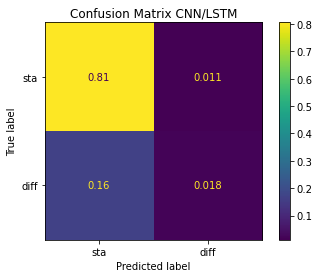

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','diff'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [15]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    Y = np_utils.to_categorical(y.astype(int),2)

    return X,Y

In [16]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(62814, 100, 6) (62814, 2)
(20871, 100, 6) (20871, 2)
(20872, 100, 6) (20872, 2)


In [17]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100, 64)           0   

In [18]:
model.load_weights('modelMSFTlstmClassification.h5')
#lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

In [19]:
#model.save('modelMSFTlstmClassification.h5')

In [20]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

653/653 [==============================] - 13s 19ms/step


array([[0.8873944 , 0.11260553],
       [0.88216615, 0.11783384],
       [0.87047344, 0.12952651],
       ...,
       [0.5153337 , 0.4846663 ],
       [0.5138073 , 0.48619267],
       [0.50802183, 0.4919781 ]], dtype=float32)

In [21]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1), digits=4))

accuracy_score: 0.8153986201609812
              precision    recall  f1-score   support

           0     0.8221    0.9881    0.8975     17066
           1     0.4345    0.0410    0.0749      3806

    accuracy                         0.8154     20872
   macro avg     0.6283    0.5145    0.4862     20872
weighted avg     0.7514    0.8154    0.7475     20872



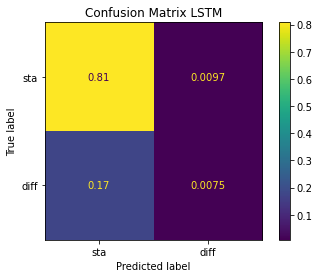

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['sta','diff'])
disp_lstm.plot()
disp_lstm.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [23]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [24]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [25]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 0.8256163273091411
              precision    recall  f1-score   support

           0     0.8447    0.9702    0.9031     17563
           1     0.3438    0.0804    0.1303      3408

    accuracy                         0.8256     20971
   macro avg     0.5942    0.5253    0.5167     20971
weighted avg     0.7633    0.8256    0.7775     20971



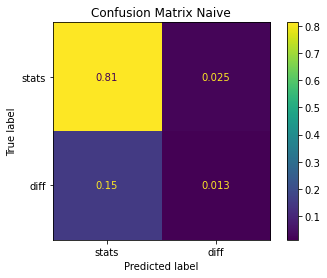

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['stats','diff'])
dispNaiv.plot()
dispNaiv.ax_.set_title("Confusion Matrix Naive");

In [ ]:
import seaborn as sns
fig, axn = plt.subplots(1,5, sharex=True, sharey=True,figsize=(12,2))

for i, ax in enumerate(axn.flat):
    k = list(cf_matrix)[i]
    sns.heatmap(cf_matrix[k], ax=ax,cbar=i==4)
    ax.set_title(k,fontsize=8)

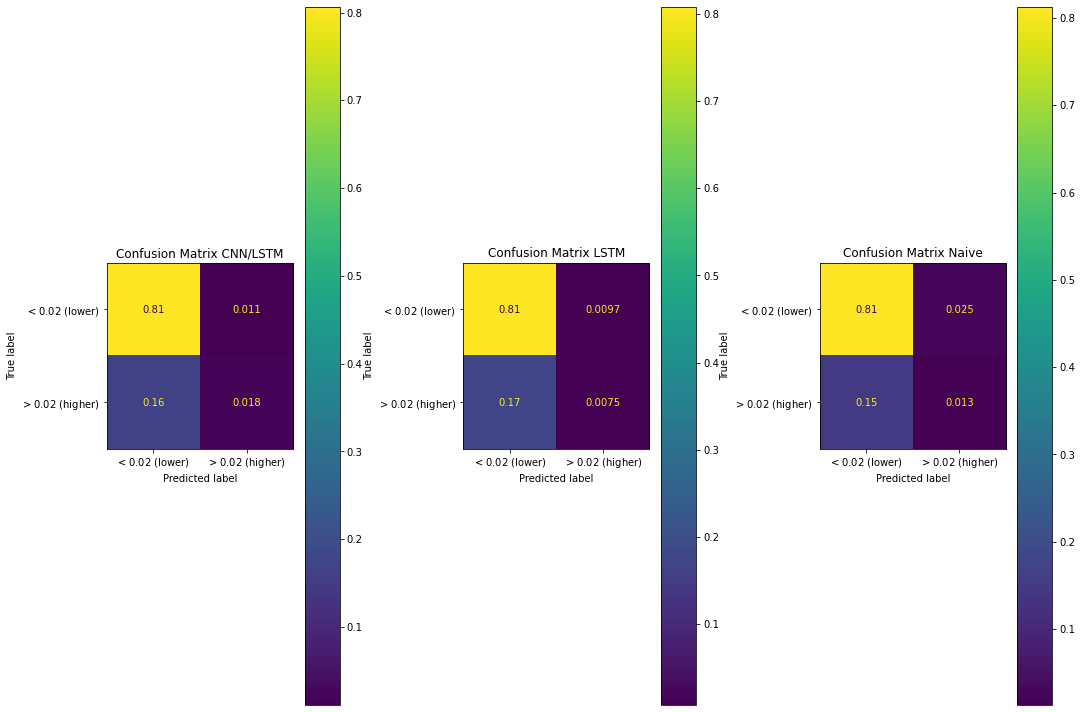

In [44]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$<0.02$ (lower)','$>0.02$ (higher)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

0.9980000000000001

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.